# ENRON Person of Interest Identifier
by Fernando Maletski

## Introduction

The famous ENRON scandal was the largest bankrupcy reorganization in the United States at the time it was publicized, October 2001. Due to the Federal investigation, a significant amount of confidential information was released to the public, including tens of thousands of emails and detailed financial data.

The objective of this project is to use this large dataset to create a machine learning model that correctly identifiers the persons of interest.

## Workspace Setup

In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib
import operator
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot') #Set a decent style
matplotlib.rcParams['image.cmap'] = 'bwr' #Diverging colors
sys.path.append("./tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

with open("final_project_dataset_py3.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## EDA, Feature Engineering and Selection

In this section we will explore the dataset, explain features and clean issues, such as missing values and outliers.

In [2]:
len(sorted(data_dict.keys()))

146

There are 146 datapoints, but one of them is an outlier, called "TOTAL", lets remove it for now:

In [3]:
data_dict.pop('TOTAL')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [4]:
len(sorted(data_dict.keys()))

145

There are 145 datapoints, each of them represents a person whose records were made puclic, the key of this dictionary is their name in this format: LAST NAME FIRST NAME (MIDDLE INICIAL):

In [5]:
persons = sorted(data_dict.keys())
persons[0:10]

['ALLEN PHILLIP K',
 'BADUM JAMES P',
 'BANNANTINE JAMES M',
 'BAXTER JOHN C',
 'BAY FRANKLIN R',
 'BAZELIDES PHILIP J',
 'BECK SALLY W',
 'BELDEN TIMOTHY N',
 'BELFER ROBERT',
 'BERBERIAN DAVID']

The values of the dictionary are another dictionary that folows this schema (key: value): feature: value.
Extracting the list of features:

In [6]:
feature_list = sorted(data_dict['ALLEN PHILLIP K'])
print(len(feature_list))
feature_list

21


['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

Testing to see if all the datapoints have the same features:

In [7]:
count = 0
for person, data in data_dict.items():
    for feature, value in data.items():
        if feature not in feature_list:
            print(person, feature)
        else:
            count += 1
total_count = len(feature_list) * len(data_dict.keys())
print('{} of {} found'.format(count, total_count))

3045 of 3045 found


Our feature list is solid. Using it, let's convert this dataset to an exploration friendly format, a pandas DataFrame:

In [8]:
df = pd.DataFrame(data_dict)
df = df.transpose()
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


Replace 'NaN' string with np.NaN for compatibility with numeric methods:

In [9]:
df.replace('NaN', np.NaN, inplace=True)

Here's a print from a random person to have an idea of the information from each datapoint:

In [10]:
df.iloc[12]

bonus                                          1e+06
deferral_payments                                NaN
deferred_income                                  NaN
director_fees                                    NaN
email_address                philippe.bibi@enron.com
exercised_stock_options                  1.46573e+06
expenses                                       38559
from_messages                                     40
from_poi_to_this_person                           23
from_this_person_to_poi                            8
loan_advances                                    NaN
long_term_incentive                           369721
other                                         425688
poi                                            False
restricted_stock                              378082
restricted_stock_deferred                        NaN
salary                                        213625
shared_receipt_with_poi                         1336
to_messages                                   

There is 2 classes of features, finance related and email related:

* **financial features:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

* **email features:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

In [11]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock',
                      'director_fees']

email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
                     'from_this_person_to_poi', 'shared_receipt_with_poi']

### Email Features

The first aproach we can take is to see if POIs communicate to each other a lot, using the features from_poi_to_this_person and from_this_person_to_poi:

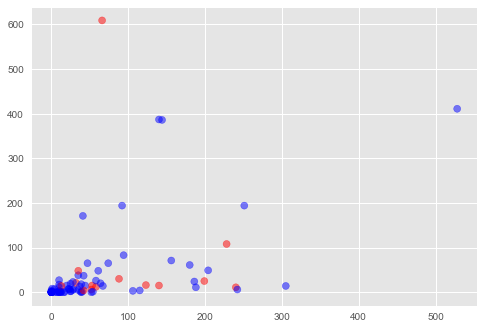

In [12]:
plt.scatter(df.from_poi_to_this_person, df.from_this_person_to_poi, c=df.poi, alpha=0.5)

It is a good idea, but there are people who sends a lot of emails and those that don't, so, engineering 2 new features, from_poi_ratio and to_poi_ratio may help:

In [13]:
df['from_poi_ratio'] = df.from_poi_to_this_person/df.to_messages
df['to_poi_ratio'] = df.from_this_person_to_poi/df.from_messages

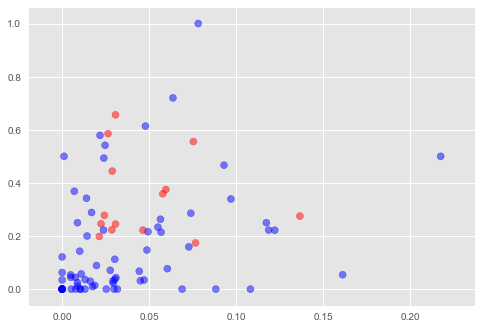

In [14]:
plt.scatter(df.from_poi_ratio, df.to_poi_ratio, c=df.poi, alpha=0.5)

Good, these features will help to filter a lot of people.

Using the same line of thought with the feature "shared_receipt_with_poi" doesn't help too much:

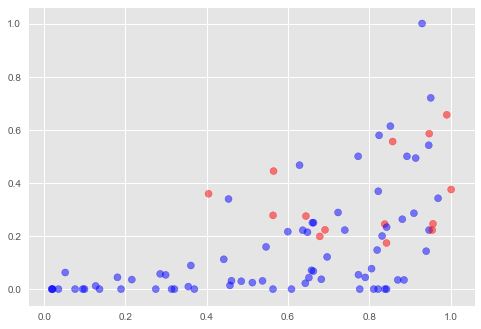

In [15]:
plt.scatter(df.shared_receipt_with_poi/df.to_messages, df.to_poi_ratio, c=df.poi, alpha=0.5)

In [16]:
selected_email_features = ['from_poi_ratio', 'to_poi_ratio']

### Financial Features

There is a lot of financial features:

In [17]:
len(financial_features)

14

While exploring and selecting them by hand is a valid approach, so is using statistics to do it. 

This code will print the p_values and F-scores of each feature (NaN is filled with 0):

FORMAT: p_value : feature : F-score

In [18]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest()
selector.fit(df[financial_features].fillna(0), df.poi)

SelectKBest(k=10, score_func=<function f_classif at 0x00000158C01AF620>)

In [19]:
for (feature, score, pvalue) in sorted(zip(financial_features, selector.scores_, selector.pvalues_),
                               key=operator.itemgetter(1), reverse=True):
    print('{:>30} :{:^30}: {}'.format(pvalue, feature, score))

         1.398443796240722e-06 :   exercised_stock_options    : 25.3801052997602
         1.844426415180382e-06 :      total_stock_value       : 24.752523020258508
         8.548240899761827e-06 :            bonus             : 21.3278904139791
        2.6464485993698053e-05 :            salary            : 18.861795316466416
         0.0008017876244783438 :       deferred_income        : 11.732698076065354
           0.00170779873759263 :     long_term_incentive      : 10.222904205832778
          0.002490134850136291 :       restricted_stock       : 9.480743203478934
          0.003239087410989142 :        total_payments        : 8.96781934767762
            0.0077240416302915 :        loan_advances         : 7.301406651536036
          0.012667743910203918 :           expenses           : 6.3746144901977475
           0.04074414136894844 :            other             : 4.263576638144469
           0.15052099606671526 :        director_fees         : 2.0893098994318806
            0

k of different alphas:

* 0.05 : k = 12
* 0.01 : k = 9
* 0.001: k = 5

Using k = 5 (pvalue < 0.001):

In [20]:
selector = SelectKBest(k=5)
filtered = selector.fit_transform(df[financial_features].fillna(0), df.poi)
selected_financial_features = []
for (feature, selected) in zip(financial_features, selector.get_support()):
    if selected:
        selected_financial_features.append(feature)

In [22]:
selected = pd.DataFrame(filtered, columns = selected_financial_features)
corr = selected.corr()
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, cmap='RdBu', 
            vmin = -1, vmax = 1, annot = True)

ValueError: Arrays were different lengths: 5 vs 0

**Obs:** It may be useful to drop and replace total_stock_value, as it is too correlated with exercised_stock_options

### Feature Selection

As per the analysis above, here are the selected features:

In [23]:
selected_features = selected_email_features + selected_financial_features
print(selected_features)

['from_poi_ratio', 'to_poi_ratio', 'salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options']


## Model Selection

As per http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html, the workflow should be:

* Linear SVC
* KN Classifier
* SVC (other kernels)
* Ensemble Classifiers (we'll try a two)
    + Random Forrest
    + Adaboost
        - Decision Trees
        - SVCs

In [24]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Prepare the dataset

In [26]:
features = df[selected_features].fillna(0)
labels = df.poi

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [27]:
from sklearn.model_selection import train_test_split

In [29]:
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)

In [30]:
clf = SVC(kernel='linear')

In [ ]:
clf.fit(features_train, labels_train)

In [ ]:
pred = clf.predict(features_test)

In [ ]:
print(accuracy_score(pred, labels_test))
print(precision_score(pred, labels_test))
print(recall_score(pred, labels_test))
print(f1_score(pred, labels_test))